In [1]:
%reload_ext autoreload
%autoreload 2

import os

import os
os.add_dll_directory(r'D:\FAUbox\Projects\PathologySuite\PathologySuite.AI.Python.Classifier\openslide-win64-20171122\bin')

import typing
from typing import Callable, Union, Dict

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
import sys
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../")
import wsi_processing_pipeline.tile_extraction
from wsi_processing_pipeline.tile_extraction import tiles, util, slide
import fastai
from fastai.vision.data import ImageList
from fastai.vision.image import pil2tensor
from fastai.basic_train import load_learner
import pandas as pd
import numpy as np
import torch


base_path = Path('/home/Deep_Learner/shared/Datasets/Hypophysenadenome/')
wsis_path = base_path/'gonadotrop'

In [2]:
wsi_path = wsis_path/'10-16-Z-HE.ndpi';wsi_path

WindowsPath('/home/Deep_Learner/shared/Datasets/Hypophysenadenome/gonadotrop/10-16-Z-HE.ndpi')

In [6]:
wsi_path = Path('D:/FAUbox/Projects/PathologySuite/PathologySuite.Blazor.ServerSide/wwwroot/histo/1739-12-III-HE.ndpi')

In [14]:
ts = tiles.WsiOrROIToTiles(wsi_path=wsi_path, 
                                                        tiles_folder_path=None, 
                                                        tile_height=512, 
                                                        tile_width=512, 
                                                        tile_naming_func=tiles.get_wsi_name_from_path_pituitary_adenoma_entities,
                                                        tile_score_thresh=0.3,
                                                        tile_scoring_function=tiles.scoring_function_1,
                                                        is_wsi=True,
                                                        level=0,
                                                        save_tiles=False,
                                                        return_as_tilesummary_object=True)

Starting to process D:\FAUbox\Projects\PathologySuite\PathologySuite.Blazor.ServerSide\wwwroot\histo\1739-12-III-HE.ndpi


In [15]:
len(ts.top_tiles())

43

In [16]:
%matplotlib inline

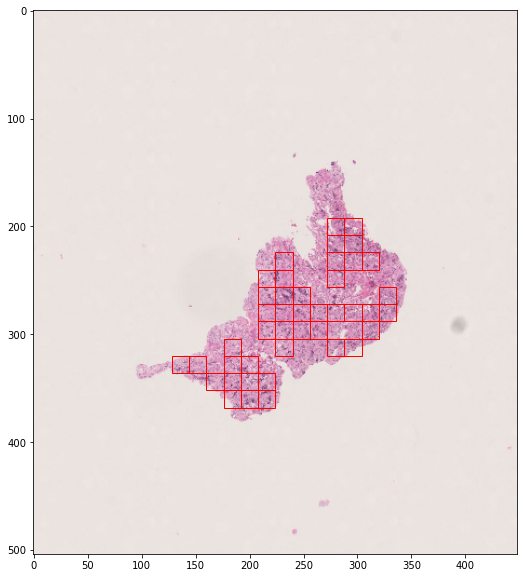

In [17]:
ts.show_wsi_with_marked_tiles()

In [18]:
tiles_df = pd.DataFrame([t.get_name() for t in ts.top_tiles()], columns=['name'])

tile_name_to_tile_object = {}
for t in ts.top_tiles():
    tile_name_to_tile_object[t.get_name()] = t

def open_custom(self, fn):
    "Open image in `fn`."
    return open_image_custom(fn, convert_mode=self.convert_mode, after_open=self.after_open)

def open_image_custom(fn:typing.Union[pathlib.Path, str], 
                      div:bool=True, 
                      convert_mode:str='RGB', 
                      cls:type=fastai.vision.Image, 
                      after_open:Callable=None)->fastai.vision.Image:
        "Open image in `fn`."
        fn = Path(fn)
        tile_name = fn.name
        t = tile_name_to_tile_object[tile_name]
        tile = tiles.ExtractTileFromWSI(path=t.wsi_path, 
                                        x=t.get_x(), 
                                        y=t.get_y(), 
                                        width=t.get_width(), 
                                        height=t.get_height(), 
                                        level=t.level)
        tile = tile.convert(convert_mode)
        if after_open: 
            tile = after_open(tile)
        tile = pil2tensor(tile,np.float32)
        if div: 
            tile.div_(255)
        return cls(tile)
        
fastai.vision.data.ImageList.open = open_custom
fastai.vision.image.open_image = open_image_custom

In [19]:
tiles_df

,name
0,1739-12-III-HE-tile-r17-c15-x7168-y8192-w512-h...
1,1739-12-III-HE-tile-r17-c16-x7680-y8192-w512-h...
2,1739-12-III-HE-tile-r16-c15-x7168-y7680-w512-h...
3,1739-12-III-HE-tile-r23-c13-x6144-y11264-w512-...
4,1739-12-III-HE-tile-r19-c20-x9728-y9216-w512-h...
5,1739-12-III-HE-tile-r18-c21-x10240-y8704-w512-...
6,1739-12-III-HE-tile-r14-c19-x9216-y6656-w512-h...
7,1739-12-III-HE-tile-r23-c14-x6656-y11264-w512-...
8,1739-12-III-HE-tile-r19-c15-x7168-y9216-w512-h...
9,1739-12-III-HE-tile-r18-c15-x7168-y8704-w512-h...


In [20]:
fn = list(tile_name_to_tile_object.keys())[0];fn

'1739-12-III-HE-tile-r17-c15-x7168-y8192-w512-h512.png'

In [21]:
img_list = ImageList.from_df(df=tiles_df, path='')

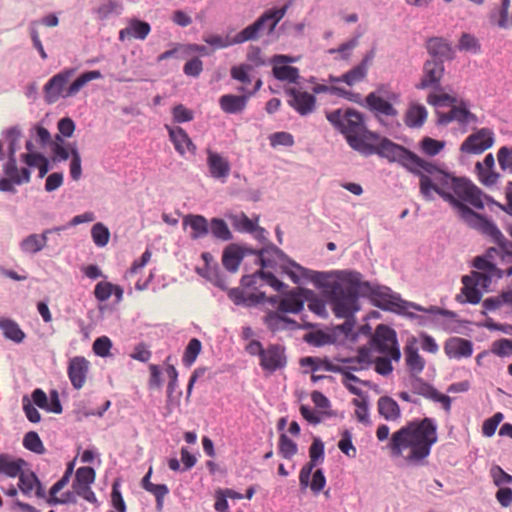

In [22]:
img_list.open(fn)

In [30]:
path_exported_learner = pathlib.Path('D:/FAUbox/Projects/PathologySuite/PathologySuite.AI.Python.Classifier/n_13-iteration_4-weights_bestmodel_lr2=1e-7--lr3=1e-6_9.pkl')

In [32]:
learner = load_learner(path=Path(path_exported_learner).parent, file=Path(path_exported_learner).name, test=img_list)

In [33]:
learner.data.batch_size = 6

In [36]:
preds = torch.stack([learner.predict(img)[2] for img in img_list[:5]])
#preds, y = learner.get_preds(ds_type=fastai.basic_data.DatasetType.Test)

In [37]:
thresh = 0.5

In [38]:
preds_bool = (preds > thresh).float()

In [39]:
preds_bool

tensor([[0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]])

In [40]:
preds_bool.sum(0)

tensor([0., 0., 4., 5.])

In [41]:
probs_wsi = preds_bool.sum(0)/len(preds_bool);probs_wsi

tensor([0.0000, 0.0000, 0.8000, 1.0000])

In [42]:
classes = ['acth', 'silent', 'lh', 'fsh']

In [43]:
result = {}
for n, c in enumerate(classes):
    result[c] = probs_wsi[n].item()

In [47]:
str(result)

"{'acth': 0.0, 'silent': 0.0, 'lh': 0.800000011920929, 'fsh': 1.0}"

In [45]:
def predict_pga_entity(path_exported_learner:Union[pathlib.Path, str], wsi_path:Union[pathlib.Path, str])->Dict:
    """
    Arguments:
        path_exported_learner: path to file that has been exported via fastai.basic_train.Learner.export()
        wsi_path: path to a whole-slide image
    Returns:
        returns a dictionary with probabilities for the classes: ['acth', 'silent', 'lh', 'fsh']
    """
    # calculate tiles 
    #tilesummaries = tiles.WsiOrROIToTilesMultithreaded(wsi_paths=[wsi_path], 
    #                                                tiles_folder_path=None, 
    #                                                tile_height=512, 
    #                                                tile_width=512, 
    #                                                tile_naming_func=tiles.get_wsi_name_from_path_pituitary_adenoma_entities,
    #                                                tile_score_thresh=0.7,
    #                                                tile_scoring_function=tiles.scoring_function_1,
    #                                                is_wsi=True,
    #                                                level=0,
    #                                                save_tiles=False,
    #                                                return_as_tilesummary_object=True)
    #ts = tilesummaries[0]

    ts = tiles.WsiOrROIToTiles(wsi_path=wsi_path, 
                                                        tiles_folder_path=None, 
                                                        tile_height=512, 
                                                        tile_width=512, 
                                                        tile_naming_func=tiles.get_wsi_name_from_path_pituitary_adenoma_entities,
                                                        tile_score_thresh=0.5,
                                                        tile_scoring_function=tiles.scoring_function_1,
                                                        is_wsi=True,
                                                        level=0,
                                                        save_tiles=False,
                                                        return_as_tilesummary_object=True)
    
    
    
    
    #overwrite fastai's function for opening images !!!TODO: change this by using a custom DataLoader Implementation
    def open_custom(self, fn):
        "Open image in `fn`."
        return open_image_custom(fn, convert_mode=self.convert_mode, after_open=self.after_open)

    def open_image_custom(fn:typing.Union[pathlib.Path, str], 
                      div:bool=True, 
                      convert_mode:str='RGB', 
                      cls:type=fastai.vision.Image, 
                      after_open:Callable=None)->fastai.vision.Image:
        "Open image in `fn`."
        fn = Path(fn)
        tile_name = fn.name
        t = tile_name_to_tile_object[tile_name]
        tile = tiles.ExtractTileFromWSI(path=t.wsi_path, 
                                        x=t.get_x(), 
                                        y=t.get_y(), 
                                        width=t.get_width(), 
                                        height=t.get_height(), 
                                        level=t.level)
        tile = tile.convert(convert_mode)
        if after_open: 
            tile = after_open(tile)
        tile = pil2tensor(tile,np.float32)
        if div: 
            tile.div_(255)
        return cls(tile)
        
    fastai.vision.data.ImageList.open = open_custom
    fastai.vision.image.open_image = open_image_custom
    
    #create fastai.vision.data.ImageList
    tiles_df = pd.DataFrame([t.get_name() for t in ts.top_tiles()], columns=['name'])

    tile_name_to_tile_object = {}
    for t in ts.top_tiles():
        tile_name_to_tile_object[t.get_name()] = t
    
    img_list = ImageList.from_df(df=tiles_df, path='')
    
    #init learner
    learner = load_learner(path=Path(path_exported_learner).parent, file=Path(path_exported_learner).name, test=img_list)
    learner.data.batch_size = 6
    
    #make predictions on tiles
    #preds, y = learner.get_preds(ds_type=fastai.basic_data.DatasetType.Test)
    preds = torch.stack([learner.predict(img)[2] for img in img_list[:5]])
    
    #calculate probabilities for the whole-slide image
    thresh = 0.5
    preds_bool = (preds > thresh).float()
    probs_wsi = preds_bool.sum(0)/len(preds_bool)
    classes = ['acth', 'silent', 'lh', 'fsh']
    result = {}
    for n, c in enumerate(classes):
        result[c] = probs_wsi[n].item()
    return result

In [46]:
predict_pga_entity(path_exported_learner=path_exported_learner, wsi_path=wsi_path)

Starting to process D:\FAUbox\Projects\PathologySuite\PathologySuite.Blazor.ServerSide\wwwroot\histo\1739-12-III-HE.ndpi


{'acth': 0.0, 'silent': 0.0, 'lh': 1.0, 'fsh': 1.0}